# Project Setup and Required Libraries

This cell contains a command to install the basic Python libraries needed for the project or to check if they are already installed in your current environment. If the libraries are already installed, you don't need to run this cell, or running it once is enough.

* `torch` and `torchvision`: For the deep learning model (PyTorch) and pre-trained models (like VGG16).
* `opencv-python`: For image processing (like resizing, changing color spaces, etc.).
* `albumentations`: A powerful library for data augmentation.
* `scipy`: For scientific calculations, especially `scipy.ndimage.gaussian_filter` which is used to create density maps.
* `matplotlib`: For creating graphs and visuals.
* `scikit-learn`: For machine learning metrics (like MAE, RMSE).
* `numpy`: For basic numerical operations and arrays.

In [1]:
# %pip install torch torchvision opencv-python albumentations scipy matplotlib scikit-learn numpy

# Importing Necessary Libraries

In this section, all the Python libraries and modules that will be used later in the project are imported. Each import is needed for a specific function in the project:

* `os`: For file and directory operations (like dataset paths, etc.).
* `cv2` (OpenCV): For reading, writing, and basic image processing operations.
* `numpy` (as np): For numerical calculations, especially for working with arrays and matrices.
* `torch`, `torch.nn`, `Dataset`, `DataLoader`, `random_split`: These are basic parts of the PyTorch library; for tensor operations, neural network layers, creating custom datasets, data loaders, and splitting datasets.
* `scipy.io.loadmat`: To read the ground truth files that are in MATLAB's `.mat` format.
* `scipy.ndimage`: The `gaussian_filter` function from here is especially used when creating density maps.
* `albumentations` (as A) and `albumentations.pytorch.ToTensorV2`: For applying advanced data augmentation techniques and for changing images into PyTorch tensors.
* `matplotlib.pyplot` (as plt): For drawing graphs related to the training process and results.
* `torchvision.models.vgg16`: To use the pre-trained VGG16 model as the base (backbone) of our convolutional neural network (CNN) model.
* `sklearn.metrics.mean_absolute_error`, `sklearn.metrics.mean_squared_error`: These are metrics for checking the model's performance – Mean Absolute Error (MAE) and Mean Squared Error (used in calculating RMSE).

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.io import loadmat
import scipy.ndimage
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchvision.models import vgg16
from sklearn.metrics import mean_absolute_error, mean_squared_error

### 2. Dataset Selection and Analysis

For this project, which is about Visual Crowd Density Estimation, we used the ShanghaiTech dataset.

#### 2.1. The ShanghaiTech Dataset
The ShanghaiTech dataset is a standard (benchmark) dataset that is often used in research for crowd counting and density estimation. It has two main parts:

* **Part A:** This part has images collected from the internet. These images usually show very crowded scenes. The number of people and how crowded it is can be very different from one image to another.
* **Part B:** This part has images taken from a busy street in Shanghai. These crowds are usually less dense and a bit more regular.

In total, there are 1,198 marked (annotated) images, and in these images, there are 330,165 people in total. The head position of each person is marked.

#### 2.2. Reasons for Choosing the Dataset
We chose the ShanghaiTech dataset for this project for these main reasons:

* **Relevance:** The dataset was made specifically for tasks like crowd analysis and density estimation. It is very suitable for our project, which is about visual crowd density estimation using "CNN + Heatmap Regression."
* **Richness and Diversity:**
    * **Different Densities:** It includes scenes with very few people and also extremely crowded scenes. This is important for testing and improving our model's ability to work well with different crowd levels.
    * **Challenging Conditions:** The images have different viewpoints, changes in scale (how big things look), people partly blocking each other (occlusion), and various lighting conditions. These challenges help make our model stronger (more robust) for real-world situations.
* **Benchmark Standard:** Many research papers in crowd counting use this dataset. This means we can compare our results with other methods in the field.
* **Ground Truth Availability:** For every image, the center of each person's head (as x, y coordinates) is marked. This information is needed to create the target density maps (ground truth density maps) using Gaussian filters. This is very important for the heatmap regression approach, which is a core part of our project.
* **Matches Project Requirements:** It meets the criteria in the "Common Requirements" document for being a dataset that is "relevant to the project topic" and "rich enough in features to allow meaningful model training and evaluation."

#### 2.3. Dataset Pre-analysis and Usage
In this project, we used both Part A and Part B of the ShanghaiTech dataset to see how well our model performs with crowds of different densities and in different conditions. The dataset was split into three parts: training, validation, and testing. During training, we used the point annotations (marks for head locations) provided as ground truth to create density maps using Gaussian kernels. These density maps are what our Convolutional Neural Network (CNN) model needs to learn to produce.

# Dataset Analysis

The `analyze_dataset` function, which is defined in this section, is used to get basic statistics from the loaded dataset. This analysis helps us understand the general structure of the dataset, how many samples it contains, and the average, minimum, and maximum number of people in each image. This information is important for understanding the challenges our model will face and for looking at how the data is distributed.

For each sample in the dataset, the function calculates the sum of the ground truth density map (which is the number of people). Then, it reports statistics based on these numbers.

In [3]:
def analyze_dataset(dataset):
    counts = [dataset[i][1].sum().item() for i in range(len(dataset))]
    print(f"Toplam görüntü sayısı: {len(dataset)}")
    if len(counts) > 0:
        print(f"Ortalama kişi sayısı: {np.mean(counts):.2f}")
        print(f"Min/Max kişi sayısı: {np.min(counts):.2f}/{np.max(counts):.2f}")
    else:
        print("Analiz için veri bulunamadı.")

# Dataset Class: `CrowdDataset`

In this part, we define a special `Dataset` class called `CrowdDataset`. This class is for loading and processing the crowd counting dataset and making it work with PyTorch's `DataLoader`. This class inherits from `torch.utils.data.Dataset` and mainly does these things:

* **`__init__(self, image_dir, gt_dir, transform=None, sigma=3)`**:
    * It takes the directory paths for the images and the ground truth (`.mat` format) files.
    * It also takes data augmentation transformations (`transform`) and the sigma value for the Gaussian filter (used when creating density maps) as parameters.
    * It reads the image and ground truth files, matches them based on their names, and stores the valid ones in lists. It tries to match files in formats like `IMG_X.jpg` and `GT_IMG_X.mat` (for ShanghaiTech Part A) or more general formats like `imageX.jpg` and `GT_imageX.mat`.
* **`__len__(self)`**: This returns the total number of samples in the dataset.
* **`__getitem__(self, idx)`**: For a given `idx` (index), this method returns one image and its matching density map. The steps in this method are:
    1.  Read the image using OpenCV (`cv2`) and change it to RGB format.
    2.  Read the ground truth `.mat` file using `scipy.io.loadmat` to get the locations (points) of people.
    3.  Resize the image to a set target size (e.g., 256x256 pixels).
    4.  Scale the original people locations to match the coordinates in the resized image.
    5.  Create a density map from these scaled points using the `generate_density_map` method.
    6.  If data augmentations are defined, apply them to the image and density map using the `albumentations` library.
    7.  Change the image and density map into PyTorch tensors and do the necessary normalization.
    8.  Finally, it returns the processed image tensor and the density map tensor.
* **`generate_density_map(self, image_shape, points)`**: This creates a 2D density map based on the given image size and people locations. At first, each person point is marked as a pixel with a value of one. Then, a Gaussian filter with the `sigma` value is applied to this point map. This spreads out each person over a small area and makes the distribution smoother. Lastly, the density map is normalized so that its sum is equal to the actual number of people. This helps the model learn a target that is directly related to the number of people.
* **`visualize_sample(self, idx)`**: This loads an original image from a specific index in the dataset and draws red circles on it to show the ground truth points. This is useful for checking if the data labels are correct and for seeing where the crowds are.

This class is the basic structure that prepares the (image, density map) pairs needed for training the model.

In [4]:
class CrowdDataset(Dataset):
    def __init__(self, image_dir, gt_dir, transform=None, sigma=3):
        self.image_dir = image_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.sigma = sigma 

        all_images_in_dir = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        all_gts_in_dir = sorted([f for f in os.listdir(gt_dir) if f.lower().endswith('.mat')])

        self.image_paths = []
        self.gt_paths = []

        gt_file_map = {}
        for gt_name in all_gts_in_dir:
            base_name_no_ext = os.path.splitext(gt_name)[0]
            if base_name_no_ext.startswith('GT_'):
                key = base_name_no_ext[3:] 
            else:
                key = base_name_no_ext 
            gt_file_map[key] = gt_name
        
        for img_name in all_images_in_dir:
            img_key = os.path.splitext(img_name)[0]

            if img_key in gt_file_map:
                img_full_path = f"{image_dir}/{img_name}".replace("\\", "/")
                
                temp_img = None
                try:
                    with open(img_full_path, "rb") as f:
                        img_bytes = f.read()
                    if img_bytes:
                        img_np_array = np.frombuffer(img_bytes, np.uint8)
                        temp_img = cv2.imdecode(img_np_array, cv2.IMREAD_COLOR)
                    else: 
                        print(f"Uyarı (CrowdDataset __init__): Görüntü dosyası '{img_name}' ('{img_full_path}') boş. Atlanıyor.")

                except IOError: 
                    print(f"Uyarı (CrowdDataset __init__): Görüntü dosyası '{img_name}' ('{img_full_path}') IO Hatası ile okunamadı. Atlanıyor.")
                except Exception as e: 
                     print(f"Uyarı (CrowdDataset __init__): Görüntü '{img_name}' ('{img_full_path}') okunurken genel bir hata oluştu: {e}. Atlanıyor.")


                if temp_img is not None:
                    self.image_paths.append(img_full_path)
                    self.gt_paths.append(os.path.join(gt_dir, gt_file_map[img_key]))
                else:
                    if img_bytes and temp_img is None: 
                         print(f"Uyarı (CrowdDataset __init__): Görüntü '{img_name}' ('{img_full_path}') cv2.imdecode ile çözümlenemedi (muhtemelen bozuk). Atlanıyor.")
            else:
                print(f"Uyarı (CrowdDataset __init__): Görüntü '{img_name}' için eşleşen GT dosyası bulunamadı. (Aranan anahtar: '{img_key}'). Atlanıyor.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        gt_path = self.gt_paths[idx]

        img = None
        try:
            with open(img_path, "rb") as f: 
                img_bytes = f.read()
            if not img_bytes: 
                raise FileNotFoundError(f"__getitem__: Görüntü dosyası boş: {img_path}")
            
            img_np_array = np.frombuffer(img_bytes, np.uint8) 
            img = cv2.imdecode(img_np_array, cv2.IMREAD_COLOR) 
            
            if img is None:
                raise FileNotFoundError(f"__getitem__: Görüntü cv2.imdecode ile çözümlenemedi (muhtemelen bozuk dosya): {img_path}")

        except FileNotFoundError as e: 
            print(f"Dosya bulunamadı veya boş (__getitem__): {img_path}")
            raise e 
        except IOError: 
            raise FileNotFoundError(f"__getitem__: Görüntü IO Hatası ile okunamadı: {img_path}")
        except Exception as e: 
            raise RuntimeError(f"__getitem__: Görüntü okunurken genel bir hata oluştu ({img_path}): {e}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mat = loadmat(gt_path)
        try:
            points = mat["image_info"][0][0][0][0][0]
        except KeyError:
            if 'annPoints' in mat:
                points = mat['annPoints']
            else:
                raise KeyError(f"GT dosyasında beklenen anahtar ('image_info' veya 'annPoints') bulunamadı: {gt_path}")

        target_h, target_w = 256, 256
        original_h, original_w = img.shape[:2]
        img_resized = cv2.resize(img, (target_w, target_h), interpolation=cv2.INTER_LINEAR)

        if original_w > 0 and original_h > 0 :
            scale_x = target_w / original_w
            scale_y = target_h / original_h
        else:
            scale_x, scale_y = 1.0, 1.0 

        scaled_points = points.copy().astype(np.float32)
        if points.shape[0] > 0: 
            scaled_points[:, 0] *= scale_x
            scaled_points[:, 1] *= scale_y
            scaled_points = scaled_points[
                (scaled_points[:, 0] >= 0) & (scaled_points[:, 0] < target_w) &
                (scaled_points[:, 1] >= 0) & (scaled_points[:, 1] < target_h)
            ]

        density_map, _ = self.generate_density_map((target_h, target_w), scaled_points)
        density_map = density_map.astype(np.float32)

        img_processed = img_resized 

        if self.transform:
            augmented = self.transform(image=img_processed, mask=density_map)
            img_tensor = augmented['image']
            density_map_tensor = augmented['mask']
            if density_map_tensor.ndim == 2:
                density_map_tensor = density_map_tensor.unsqueeze(0)
        else:
            img_tensor = torch.from_numpy(img_processed.transpose(2, 0, 1)).float() / 255.0
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) 
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_tensor = (img_tensor - mean) / std
            density_map_tensor = torch.from_numpy(density_map).unsqueeze(0).float()

        
        expected_img_shape = (3, target_h, target_w)
        expected_dm_shape = (1, target_h, target_w) 
        if img_tensor.shape != expected_img_shape:
                raise ValueError(f"__getitem__: Görüntü tensör boyutu ({img_tensor.shape}) beklenenden ({expected_img_shape}) farklı. idx: {idx}, path: {img_path}")
        if density_map_tensor.shape != expected_dm_shape:
                raise ValueError(f"__getitem__: Yoğunluk haritası tensör boyutu ({density_map_tensor.shape}) beklenenden ({expected_dm_shape}) farklı. idx: {idx}, path: {gt_path}")

        return img_tensor, density_map_tensor

    def generate_density_map(self, image_shape, points):
        h, w = image_shape
        density_map = np.zeros((h, w), dtype=np.float32)
        num_people = len(points)

        if num_people == 0:
            return density_map, 1.0

        for p_idx in range(num_people):
            point = points[p_idx]
            x = min(max(0, int(point[0])), w - 1)
            y = min(max(0, int(point[1])), h - 1)
            density_map[y, x] += 1.0

        density_map = scipy.ndimage.gaussian_filter(density_map, sigma=self.sigma, mode='constant')
        
        current_sum = density_map.sum()
        scale_factor = 1.0
        if current_sum > 1e-8: 
            scale_factor = num_people / current_sum
            density_map *= scale_factor

        return density_map, scale_factor

    def visualize_sample(self, idx):
        img_path = self.image_paths[idx]
        gt_path = self.gt_paths[idx]

        original_img = None
        try:
            with open(img_path, "rb") as f:
                img_bytes = f.read()
            if not img_bytes:
                print(f"visualize_sample: Görüntü dosyası boş: {img_path}")
                return

            img_np_array = np.frombuffer(img_bytes, np.uint8)
            original_img = cv2.imdecode(img_np_array, cv2.IMREAD_COLOR)
            
            if original_img is None:
                print(f"visualize_sample: Görüntü '{os.path.basename(img_path)}' cv2.imdecode ile çözümlenemedi. Atlanıyor.")
                return

        except FileNotFoundError:
            print(f"visualize_sample: Görüntü dosyası bulunamadı: {img_path}")
            return
        except IOError:
            print(f"visualize_sample: Görüntü IO Hatası ile okunamadı: {img_path}")
            return
        except Exception as e:
            print(f"visualize_sample: Görüntü okunurken genel bir hata oluştu ({img_path}): {e}")
            return

        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        mat = loadmat(gt_path)
        try:
            points = mat["image_info"][0][0][0][0][0]
        except KeyError:
            points = mat.get('annPoints', np.array([]))

        img_with_points = original_img.copy()
        if points.ndim == 2 and points.shape[0] > 0: 
            for point in points:
                if len(point) >= 2:
                    x, y = int(point[0]), int(point[1])
                    cv2.circle(img_with_points, (x, y), radius=max(1,int(original_img.shape[0]/100)), color=(255, 0, 0), thickness=-1)

        plt.figure(figsize=(10, 6))
        plt.imshow(img_with_points)
        num_actual_points = len(points) if points.ndim == 2 else 0
        plt.title(f"Orijinal Görüntü: {os.path.basename(img_path)} - Kişi Sayısı: {num_actual_points}")
        plt.axis("off")
        plt.show()

### Data Preprocessing

To help the model work well with raw images and their ground truth data, we did several preprocessing steps. These steps were applied in the same way to all parts of the data (training, validation, and test sets). The goal was to standardize the data and make it ready for model training.

The main preprocessing steps are:

1.  **Image Loading and Color Space Conversion:**
    * Images are loaded using OpenCV (`cv2.imread`). By default, OpenCV reads images in BGR (Blue-Green-Red) format.
    * Since models are usually trained with RGB (Red-Green-Blue) format, the loaded images are changed from BGR to RGB using the `cv2.cvtColor(image, cv2.COLOR_BGR2RGB)` command.

2.  **Ground Truth Density Map Generation:**
    * For each image in the dataset, we use the provided point annotations (centers of people's heads) to create ground truth density maps.
    * This is done by placing a Gaussian kernel (a small bump) at each annotation point and then adding these kernels together. In this project, we made density maps using either a geometric-adaptive Gaussian filter (which changes the sigma value based on how crowded it is) or a fixed sigma value (inside the `gaussian_filter_density` function).
    * These created density maps are the target data that our model will learn to predict.

3.  **Resizing:**
    * Input images and density maps can have different sizes. To make them all a fixed size that the model expects (for example, 256x256 pixels in this project), we use `albumentations.Resize`. This makes sure the model gets consistent inputs and helps with processing data in batches.

4.  **Normalization:**
    * Image pixels are usually normalized using the mean and standard deviation values from the ImageNet dataset (`albumentations.Normalize`). This step scales the pixel values to a certain range. It helps the model train faster, makes the training more stable, and helps it find a good solution.

5.  **Tensor Conversion:**
    * Finally, the preprocessed images and density maps (which are in NumPy array format) are changed into PyTorch tensors (`albumentations.ToTensorV2`). When this happens, the order of image channels is changed from (Height, Width, Channel) to what PyTorch expects, which is (Channel, Height, Width).

These preprocessing steps aim to improve the model's performance by putting the dataset into a suitable, standard, and optimized format for training a deep learning model.

# Data Augmentation

Data augmentation is an important technique used to make the model better at generalizing and to reduce overfitting (when the model learns the training data too well and doesn't work on new data). It works by artificially creating new and different examples from the existing training data. In this project, we use the `albumentations` library to apply several augmentation methods one after another (in a `Compose` pipeline).

The main data augmentation techniques we applied are:

* **`A.RandomBrightnessContrast`**: Randomly changes the brightness and contrast of the image.
* **`A.HueSaturationValue`**: Randomly changes the hue, saturation, and value (brightness) of the image's colors.
* **`A.GaussNoise`**: Adds random Gaussian noise to the image.
* **`A.ShiftScaleRotate`**: Randomly shifts, scales (zooms in/out), and rotates the image. With `border_mode=cv2.BORDER_CONSTANT`, any empty spaces created by these changes are filled with a constant value.
* **`A.HorizontalFlip`**: Flips the image horizontally with a 50% chance.
* **`A.RandomCrop`**: Takes a random 224x224 sized piece from the image. This helps the model focus on different parts of the image. It is applied with a low chance (`p=0.2`).
* **`A.Resize`**: After cropping or other changes to the size, this always resizes the image back to the target size of 256x256.
* **`A.Normalize`**: Normalizes the image pixels, usually using the mean and standard deviation values from the ImageNet dataset. This helps the model learn faster and more stably.
* **`ToTensorV2`**: Changes the image (and mask) from NumPy array format to PyTorch tensors. For the image, it also changes the order of channels from (H,W,C) to (C,H,W).

These transformations are applied to both the input image and the matching density map (which is called 'mask') at the same time, thanks to the `additional_targets={'mask': 'mask'}` argument. This makes sure that when we do geometric changes (like rotating or cropping), the density map stays consistent with the image.

In short, these augmentation techniques were used to make the model more robust (stronger) against different visual conditions like various lighting, colors, noise levels, object positions, scales, and angles. They also help prevent overfitting and, as a result, help develop a density estimation model that can generalize better to data it has not seen before.

In [5]:
train_transform = A.Compose([
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p=0.5),
    A.RandomCrop(height=224, width=224, p=0.2),
    A.Resize(height=256, width=256, always_apply=True, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17336\4027548285.py:4: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0), p=0.2),
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17336\4027548285.py:8: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=256, width=256, always_apply=True, interpolation=cv2.INTER_LINEAR),


# Preparing the Dataset and Data Loaders

In this section, we create dataset objects and DataLoaders for training the model.

1.  **File Paths:** First, we set the directory paths for the images (`image_dir`) and the ground truth `.mat` files (`gt_dir`). It's important that these paths point to the correct locations on your system.

2.  **Creating the `CrowdDataset` Object:**
    * Using the paths, the `train_transform` (for data augmentation), and a `sigma=3` value for the density map, we create a `full_dataset` object from the `CrowdDataset` class.
    * The total number of loaded data samples is printed. If no data is found, the program will stop with an error message.

3.  **Splitting the Dataset into Training and Validation Sets:**
    * The `dataset_to_use` variable (which is currently equal to `full_dataset`) is used to split the dataset into two parts: training and validation. By default, 80% is used for training and 20% for validation (`train_val_split_ratio = 0.8`).
    * If the dataset is very small (e.g., <10 samples), a warning is given, and the splitting strategy is adjusted.
    * The `random_split` function splits the data randomly according to the given ratios. To get repeatable results, it uses a fixed seed (`generator=torch.Generator().manual_seed(42)`).
    * The number of samples in the training and validation sets is printed.

4.  **Creating `DataLoader` Objects:**
    * Separate `DataLoader` objects are created for the `train_dataset` and `val_dataset`.
    * The `DataLoader` helps get data in batches (mini-groups) from the dataset. It also shuffles the data (`shuffle=True` for training), speeds up data loading using multiple threads (`num_workers`), and uses `pin_memory=True` for faster data transfer to the GPU.
    * `batch_size` is set to 4; this value can be changed based on GPU memory and how complex the model is.
    * `num_workers` is set to 0. This might be chosen to avoid problems with multi-processing on some systems (especially Windows) or to make debugging easier. This value can be increased (e.g., 2, 4) for faster data loading, but it depends on system resources.

5.  **Dataset Analysis and Sample Visualization:**
    * The `analyze_dataset` function is called to get general statistics about the entire loaded dataset.
    * The first sample from the training set (`train_dataset[0]`) is taken. The shapes of its image and density map tensors, their value ranges, and the sum of the density map (approximate number of people) are printed.
    * This first sample image (after data augmentation and normalization) and its corresponding density map are visualized using `matplotlib`.
    * Also, the original (non-augmented) version of the same sample, with the person locations marked on it, is shown using the `visualize_sample` method. This is important to confirm that the data loading and processing steps are correct.

Toplam 300 veri bulundu.
Eğitim için kullanılacak veri sayısı: 300
Eğitim seti boyutu: 240, Doğrulama seti boyutu: 60
Toplam görüntü sayısı: 300
Ortalama kişi sayısı: 536.71
Min/Max kişi sayısı: 31.85/2846.92
Örnek Görüntü Tensör Şekli: torch.Size([3, 256, 256])
Örnek Yoğunluk Haritası Tensör Şekli: torch.Size([1, 256, 256])
Örnek Yoğunluk Haritası Değer Aralığı: [0.0000, 0.3219]
Örnek Yoğunluk Haritası Toplamı (Kişi Sayısı): 1335.13


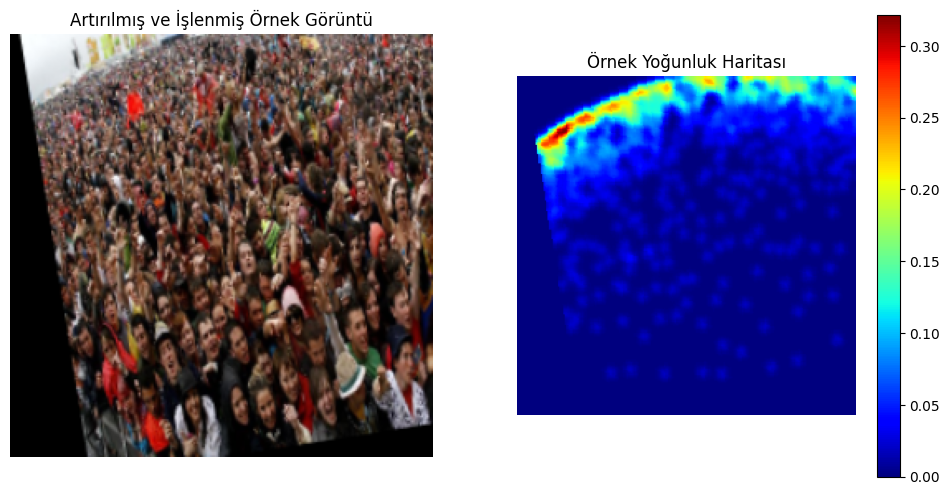

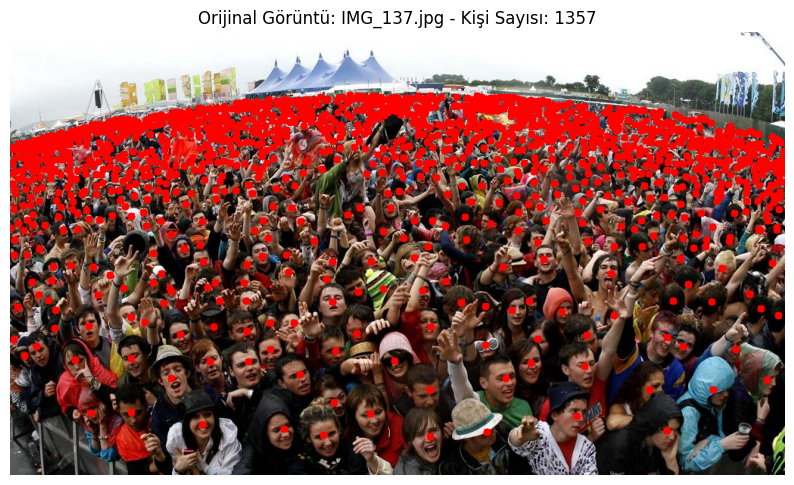

In [6]:
image_dir = r"C:/Users/ASUS/OneDrive/Masaüstü/VisualCrowdDensityEstimation/Crowd_Counting/part_A_final/train_data/images"
gt_dir = r"C:/Users/ASUS/OneDrive/Masaüstü/VisualCrowdDensityEstimation/Crowd_Counting/part_A_final/train_data/ground_truth"

full_dataset = CrowdDataset(image_dir=image_dir, gt_dir=gt_dir, transform=train_transform, sigma=3)
print(f"Toplam {len(full_dataset)} veri bulundu.")

if len(full_dataset) == 0:
    raise SystemExit("Veri seti yüklenemedi veya boş. Lütfen dosya yollarını ve CrowdDataset __init__ metodundaki eşleştirme mantığını kontrol edin.")

dataset_to_use = full_dataset 
print(f"Eğitim için kullanılacak veri sayısı: {len(dataset_to_use)}")

train_val_split_ratio = 0.8
if len(dataset_to_use) < 10: 
    print(f"Uyarı: Veri seti boyutu ({len(dataset_to_use)}) çok küçük. Eğitim ve doğrulama için yeterli olmayabilir.")
    if len(dataset_to_use) < 5:
        train_size = len(dataset_to_use)
        val_size = 0
    else: 
        train_size = len(dataset_to_use) - 1
        val_size = 1
else:
    train_size = int(train_val_split_ratio * len(dataset_to_use))
    val_size = len(dataset_to_use) - train_size

if val_size == 0 and len(dataset_to_use) >= 5 : 
    val_size = max(1, int(len(dataset_to_use) * (1-train_val_split_ratio))) 
    train_size = len(dataset_to_use) - val_size


train_dataset, val_dataset = random_split(dataset_to_use, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Eğitim seti boyutu: {len(train_dataset)}, Doğrulama seti boyutu: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

if len(full_dataset) > 0:
    analyze_dataset(full_dataset)

def denormalize(tensor): 
    device = tensor.device 
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    return tensor * std + mean

if len(train_dataset) > 0:
    img_sample, heatmap_sample = train_dataset[0]
    print(f"Örnek Görüntü Tensör Şekli: {img_sample.shape}")
    print(f"Örnek Yoğunluk Haritası Tensör Şekli: {heatmap_sample.shape}")
    print(f"Örnek Yoğunluk Haritası Değer Aralığı: [{heatmap_sample.min():.4f}, {heatmap_sample.max():.4f}]")
    print(f"Örnek Yoğunluk Haritası Toplamı (Kişi Sayısı): {heatmap_sample.sum().item():.2f}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    img_denorm_sample = denormalize(img_sample.cpu()).permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img_denorm_sample, 0, 1))
    plt.title("Artırılmış ve İşlenmiş Örnek Görüntü")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_sample.cpu().squeeze(0).numpy(), cmap='jet') 
    plt.title("Örnek Yoğunluk Haritası")
    plt.colorbar()
    plt.axis('off')
    plt.show()

    if isinstance(train_dataset.dataset, CrowdDataset):
         train_dataset.dataset.visualize_sample(train_dataset.indices[0])
    elif isinstance(train_dataset.dataset, torch.utils.data.Subset) and hasattr(train_dataset.dataset.dataset, 'visualize_sample'):
         original_dataset = train_dataset.dataset.dataset
         original_index = train_dataset.indices[0]
         original_dataset.visualize_sample(original_index)

# Model Architecture: `CrowdCNN`

This section describes the Convolutional Neural Network (CNN) model, named `CrowdCNN`, which will be used for crowd density map estimation. The model is based on a popular U-Net like architecture and uses a pre-trained VGG16 network (trained on ImageNet) as its feature extractor (encoder).

* **`__init__(self, pretrained=True)`**:
    * This initializes the model's structure. If `pretrained=True`, the ImageNet weights of the VGG16 network are loaded. This helps the model learn faster and better through transfer learning.
    * **Encoder:** The convolutional layers of VGG16 (`vgg_model.features`) are used as the encoder. This encoder is split into five blocks (from `encoder1` to `encoder5`) to get feature maps from different depth levels (which means different resolutions and receptive fields). Each block contains specific layer sections from VGG16.
        * `encoder1`: The first convolution block captures high-resolution, low-level features.
        * `encoder2` to `encoder5`: Deeper layers capture more complex and abstract features, but their resolution decreases (because of pooling layers). `encoder5` is the deepest (bottleneck) layer.
    * **Decoder:** A decoder structure is used to create a density map at the original image size from the compressed features extracted by the encoder. The decoder works like in the U-Net architecture:
        * Each decoder block (from `decoder5` to `decoder1`) takes the output of the previous decoder block and doubles its size using `nn.Upsample` (upsampling).
        * This upsampled feature map is then combined (using `torch.cat`) with the feature map taken from the matching level of the encoder (this is a skip connection). This allows both low-level details and high-level semantic information to contribute to the final prediction.
        * The combined features are passed through a series of operations including convolution layers (`nn.Conv2d`), `BatchNorm2d` (for normalization), and `nn.ReLU` (for activation).
        * At the end of `decoder1`, the 32-channel feature map is reduced to a single channel (for the density map) using `nn.Conv2d(32, 1, kernel_size=1)`.
        * Finally, an `nn.ReLU` activation function is applied to make sure the density map values are not negative.
* **`forward(self, x)`**: This defines the model's forward pass logic.
    1.  The input image (`x`) is passed through the encoder blocks in order, and the output of each encoder block (from `e1` to `e5`) is saved.
    2.  `e5` (the bottleneck output) goes into the first decoder block (`decoder5`).
    3.  Each following decoder block combines the upsampled output from the previous decoder with the feature map from the matching level of the encoder and processes it.
    4.  The output of the final `decoder1` block is returned as the predicted density map.

This architecture is designed to effectively estimate density maps by capturing both local details and global context.

In [7]:
class CrowdCNN(nn.Module):
    def __init__(self, pretrained=True):
        super(CrowdCNN, self).__init__()
        vgg_model = vgg16(weights='VGG16_Weights.IMAGENET1K_V1' if pretrained else None)
        self.encoder_features = vgg_model.features

        self.encoder1 = self.encoder_features[:4] 
        self.encoder2 = self.encoder_features[4:9] 
        self.encoder3 = self.encoder_features[9:16] 
        self.encoder4 = self.encoder_features[16:23]
        self.encoder5 = self.encoder_features[23:30]

        self.decoder5 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.decoder4 = nn.Sequential( 
            nn.Conv2d(512 + 256, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.decoder3 = nn.Sequential( 
            nn.Conv2d(256 + 128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) 
        )
        self.decoder1 = nn.Sequential(
            nn.Conv2d(64 + 64, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1), 
            nn.ReLU() 
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4) 

        d5 = self.decoder5(e5)
        d4 = self.decoder4(torch.cat([d5, e4], dim=1))
        d3 = self.decoder3(torch.cat([d4, e3], dim=1))
        d2 = self.decoder2(torch.cat([d3, e2], dim=1))
        d1 = self.decoder1(torch.cat([d2, e1], dim=1))
        return d1


# Model Initialization and Device Settings

In this cell, an object of the defined `CrowdCNN` model is created, and the device (GPU or CPU) where the training will happen is determined.

1.  **Determining the Device (`device`):**
    * The command `torch.cuda.is_available()` checks if there is an available NVIDIA GPU on the system.
    * If a GPU is available, the `device` variable is set to `"cuda"`; otherwise, it is set to `"cpu"`. This ensures that the model and data are sent to the correct device.
    * The device that will be used is printed to the screen.

2.  **Creating the Model and Moving it to the Device:**
    * The model object is created by calling `CrowdCNN(pretrained=True)`, which uses the pre-trained VGG16 weights.
    * The model is moved to the determined device (GPU or CPU) using the `.to(device)` method. This makes sure that the model's weights and calculations are handled on that device.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

model = CrowdCNN(pretrained=True).to(device)

Kullanılan cihaz: cuda


# Loss Function, Training, and Validation Routines

In this part, we define the basic functions needed for training the model and checking its performance.

### `combined_loss(outputs, targets, sum_loss_weight=1.0)`
This function calculates the loss (how wrong the model's predictions are) between the model's `outputs` and the real `targets`. It has two parts:
1.  **`mse_loss` (Pixel-wise Mean Squared Error):** This is calculated using `nn.MSELoss()`. It takes the average of the squared differences between the pixels of the predicted density map and the real density map. This aims to make the model predict the overall structure and values of the density map correctly.
2.  **`sum_loss` (Relative Count Error):**
    * First, for each image, the predicted number of people (`pred_counts`) and the real number of people (`true_counts`) are found by adding up all the pixels in their respective density maps.
    * Then, for each sample, the relative absolute error is calculated using the formula: `|predicted_count - real_count| / real_count`. We use `true_counts.clamp(min=1e-8)` to avoid dividing by zero.
    * The `sum_loss` is found by taking the average (`mean()`) of these per-sample relative errors. This part of the loss helps the model focus on predicting the total number of people correctly.
3.  **Total Weighted Loss:** These two loss parts are combined using the `sum_loss_weight` parameter (which is the weight for the count error loss): `weighted_total_loss = mse_loss + sum_loss_weight * sum_loss`. This weight decides how much importance is given to counting correctly.
The function returns the total weighted loss, the MSE loss, and the Sum loss separately.

---
### `train_one_epoch(...)`
This function trains the model for one epoch (one full pass through the entire dataset):
1.  It sets the model to training mode with `model.train()`.
2.  It starts variables to keep track of the total loss, MSE loss, and Sum loss during the epoch.
3.  It gets training data (images and targets) in batches from the `dataloader`.
4.  It moves the data to the specified `device`.
5.  It makes predictions (`outputs`) with the model.
6.  It checks if the size of the predictions and targets match. If not, it tries a simple adjustment or gives an error.
7.  It calculates the loss values by calling the `combined_loss` function.
8.  It resets the optimizer's gradients (`optimizer.zero_grad()`), does backpropagation based on the loss (`loss.backward()`), and updates the model's weights (`optimizer.ste()).
9.  It adds the calculated loss parts to the totals.
10. After a certain number of batches are processed, it prints the current loss value to show progress.
11. At the end of the epoch, it returns the average total loss, average MSE loss, and average Sum loss.

---
### `validate(...)`
This function checks the model's validation performance for one epoch:
1.  It sets the model to evaluation mode with `model.eval()` (in this mode, layers like `BatchNorm` and `Dropout` act differently).
2.  It runs inside a `torch.no_grad()` block, which turns off gradient calculations. This uses memory and computation efficiently.
3.  It gets validation data in batches from the `dataloader`.
4.  It calculates the loss parts using `combined_loss`.
5.  It also calculates the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) metrics by finding the real and predicted number of people for each image.
6.  At the end of the epoch, it returns the average loss parts, and the MAE and RMSE values.

In [9]:
def combined_loss(outputs, targets, sum_loss_weight=1.0):
    mse_loss = nn.MSELoss()(outputs, targets)
    pred_counts = outputs.sum(dim=(1,2,3))
    true_counts = targets.sum(dim=(1,2,3))
    sum_loss = (torch.abs(pred_counts - true_counts) / true_counts.clamp(min=1e-8)).mean()
    return mse_loss + sum_loss_weight * sum_loss, mse_loss, sum_loss

def train_one_epoch(model, dataloader, optimizer, device, current_sum_loss_weight, epoch_num, total_epochs):
    model.train() 
    total_epoch_loss = 0.0
    total_mse_loss = 0.0
    total_sum_loss = 0.0
    
    num_batches = len(dataloader)
    if num_batches == 0:
        print(f"    Epoch {epoch_num}/{total_epochs} - Uyarı: Eğitim için hiç batch bulunamadı.")
        return 0.0, 0.0, 0.0

    print_every_n_batches = max(1, num_batches // 10) 
    if print_every_n_batches == 0 and num_batches > 0 : print_every_n_batches = 1

    print(f"    Epoch {epoch_num}/{total_epochs} - Eğitim başlıyor ({num_batches} batch)...")
    for i, (images, targets) in enumerate(dataloader):
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)

        if outputs.shape != targets.shape:
            if outputs.ndim == 3 and targets.ndim == 4 and targets.shape[1] == 1: 
                outputs = outputs.unsqueeze(1)
            elif targets.ndim == 3 and outputs.ndim == 4 and outputs.shape[1] == 1: 
                targets = targets.unsqueeze(1)
            if outputs.shape != targets.shape or outputs.shape[1] != 1: 
                raise ValueError(f"Eğitim Boyut Hatası (E{epoch_num} B{i+1}): Out {outputs.shape}, Tar {targets.shape}")
        
        loss, mse_l, sum_l = combined_loss(outputs, targets, sum_loss_weight=current_sum_loss_weight)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_epoch_loss += loss.item()
        total_mse_loss += mse_l.item()
        total_sum_loss += sum_l.item()

        if (i + 1) % print_every_n_batches == 0 or (i + 1) == num_batches :
            print(f"    Epoch {epoch_num} - Batch {i+1}/{num_batches} tamamlandı. Anlık Kayıp: {loss.item():.4f}")
    
    avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else 0.0
    avg_mse_loss = total_mse_loss / num_batches if num_batches > 0 else 0.0
    avg_sum_loss = total_sum_loss / num_batches if num_batches > 0 else 0.0
    return avg_epoch_loss, avg_mse_loss, avg_sum_loss

def validate(model, dataloader, device, current_sum_loss_weight, epoch_num, total_epochs):
    model.eval()
    total_epoch_loss = 0.0
    total_mse_loss = 0.0
    total_sum_loss = 0.0
    true_counts_list = []
    pred_counts_list = []

    num_batches = len(dataloader)
    if num_batches == 0:
        print(f"    Epoch {epoch_num}/{total_epochs} - Uyarı: Doğrulama için hiç batch bulunamadı.")
        return 0.0, 0.0, 0.0, float('nan'), float('nan')

    print(f"    Epoch {epoch_num}/{total_epochs} - Doğrulama başlıyor ({num_batches} batch)...")
    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)

            if outputs.shape != targets.shape:
                if outputs.ndim == 3 and targets.ndim == 4 and targets.shape[1] == 1:
                    outputs = outputs.unsqueeze(1)
                elif targets.ndim == 3 and outputs.ndim == 4 and outputs.shape[1] == 1:
                    targets = targets.unsqueeze(1)
                if outputs.shape != targets.shape or outputs.shape[1] != 1:
                    raise ValueError(f"Doğrulama Boyut Hatası (E{epoch_num} B{i+1}): Out {outputs.shape}, Tar {targets.shape}")

            loss, mse_l, sum_l = combined_loss(outputs, targets, sum_loss_weight=current_sum_loss_weight)
            
            total_epoch_loss += loss.item()
            total_mse_loss += mse_l.item()
            total_sum_loss += sum_l.item()
            pred_counts_list.extend(outputs.sum(dim=(1,2,3)).cpu().numpy())
            true_counts_list.extend(targets.sum(dim=(1,2,3)).cpu().numpy())
            
    avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else 0.0
    avg_mse_loss = total_mse_loss / num_batches if num_batches > 0 else 0.0
    avg_sum_loss = total_sum_loss / num_batches if num_batches > 0 else 0.0
    
    mae = float('nan')
    rmse = float('nan')
    if true_counts_list and pred_counts_list :
        mae = mean_absolute_error(true_counts_list, pred_counts_list)
        rmse = np.sqrt(mean_squared_error(true_counts_list, pred_counts_list))
        
    return avg_epoch_loss, avg_mse_loss, avg_sum_loss, mae, rmse

# Helper Visualization Functions

In this section, two visualization functions are defined. These are used to better understand the training process and the results:

### `visualize_augmentations(dataset_obj, idx=0, n_samples=5)`
This function is used to show how the data augmentation steps affect an image.
1.  An original image is loaded using the given `dataset_obj` (which can be a `Dataset` or `Subset` object) and `idx` (sample index).
2.  Data augmentation transformations are applied to this original image `n_samples` times.
3.  Each augmented sample is then "denormalized" (the normalization is reversed) and plotted side-by-side using `matplotlib`.

This is useful for seeing the variety of the applied augmentation techniques and how they add differences to the training data.

---
### `visualize_prediction_comparison(model_to_eval, dataset_obj, idx_in_subset, device_to_use, apply_smoothing=True, smoothing_sigma=1.0)`
This function shows a comparison of a trained model's prediction on a specific sample with the ground truth. It also offers an option to apply a Gaussian filter to the predicted density map to improve visual quality and make it smoother.

1.  An input image and its real density map are taken using the given `dataset_obj` and `idx_in_subset`.
2.  The input image is given to the model, and the raw (unfiltered) predicted density map is obtained.
3.  If `apply_smoothing=True`, a Gaussian filter with the specified `smoothing_sigma` value is applied to this raw prediction map. This usually makes the raw predictions, which can look "speckled," smoother and visually easier to understand.
4.  The sums (number of people) of both the real density map and the (if applied, smoothed) predicted density map are calculated. The number of people from the model's raw output is also kept as a reference.
5.  Using `matplotlib`, the following are shown in a three-panel display:
    * **Left panel:** The original input image (denormalized).
    * **Middle panel:** The real density map, with the real number of people on it.
    * **Right panel:** The density map predicted by the model (the smoothed version if `apply_smoothing=True`, otherwise the raw version). The title includes the number of people calculated from the shown map and information about whether smoothing was applied. The color scale of the prediction map is tried to be kept the same as the ground truth map for easier comparison.

This visualization is very important for understanding where the model does well, where it struggles, how accurately it can predict the density distribution, and how a simple post-processing step can improve the visual quality.

In [10]:
def visualize_augmentations(dataset_obj, idx=0, n_samples=5): 
    if isinstance(dataset_obj, torch.utils.data.Subset):
        original_dataset = dataset_obj.dataset
        if idx < len(dataset_obj.indices):
             original_idx = dataset_obj.indices[idx]
        else:
            print(f"Uyarı: İstenen index ({idx}) subset sınırları ({len(dataset_obj.indices)}) dışında.")
            return
    else:
        original_dataset = dataset_obj
        original_idx = idx

    if not hasattr(original_dataset, 'image_paths') or original_idx >= len(original_dataset.image_paths):
        print(f"Uyarı: Augmentasyon görselleştirmesi için geçerli örnek ({original_idx}) bulunamadı.")
        return

    img_path = original_dataset.image_paths[original_idx]
    img_orig = cv2.imread(img_path)
    if img_orig is None:
        print(f"Uyarı: Augmentasyon için görüntü yüklenemedi: {img_path}")
        return
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_resized_orig = cv2.resize(img_orig, (256, 256)) 

    fig, axs = plt.subplots(1, n_samples, figsize=(15, 3 * n_samples // 2))
    if n_samples == 1: axs = [axs] 

    for i in range(n_samples):
        dummy_mask = np.zeros((256,256), dtype=np.float32)
        if original_dataset.transform:
            augmented = original_dataset.transform(image=img_resized_orig.copy(), mask=dummy_mask)
            augmented_img_tensor = augmented['image']
            
            img_np = denormalize(augmented_img_tensor.cpu()).permute(1, 2, 0).numpy()
            axs[i].imshow(np.clip(img_np, 0, 1))
            axs[i].set_title(f"Artırma #{i+1}")
        else:
            axs[i].imshow(img_resized_orig)
            axs[i].set_title("Orijinal (Transform Yok)")
        axs[i].axis('off')
    plt.suptitle("Veri Artırma Örnekleri (Görüntüye Uygulanan)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

import scipy.ndimage 

def visualize_prediction_comparison(model_to_eval, dataset_obj, idx_in_subset, device_to_use, 
                                    apply_smoothing=False, smoothing_sigma=1.0): # Yeni parametreler
    model_to_eval.eval() 

    if isinstance(dataset_obj, torch.utils.data.Subset):
        if idx_in_subset >= len(dataset_obj):
            print(f"Uyarı: Tahmin görselleştirmesi için istenen index ({idx_in_subset}) subset sınırları dışında.")
            return None, None, None 
        image_tensor, true_density_tensor = dataset_obj[idx_in_subset]
    else: 
        if idx_in_subset >= len(dataset_obj):
            print(f"Uyarı: Tahmin görselleştirmesi için istenen index ({idx_in_subset}) dataset sınırları dışında.")
            return None, None, None 
        image_tensor, true_density_tensor = dataset_obj[idx_in_subset]

    input_tensor = image_tensor.unsqueeze(0).to(device_to_use)
    
    with torch.no_grad():
        output_density_tensor = model_to_eval(input_tensor)
        predicted_density_np_raw = output_density_tensor.squeeze().cpu().numpy() 
    
    true_density_np = true_density_tensor.squeeze().cpu().numpy()
    
    if apply_smoothing:
        predicted_density_np_smoothed = scipy.ndimage.gaussian_filter(predicted_density_np_raw, sigma=smoothing_sigma)
        predicted_count_display = predicted_density_np_smoothed.sum()
        title_suffix = f" (Pürüzsüzleştirilmiş, Sigma={smoothing_sigma})"
        density_to_show = predicted_density_np_smoothed
    else:
        predicted_count_display = predicted_density_np_raw.sum()
        title_suffix = " (Ham Tahmin)"
        density_to_show = predicted_density_np_raw

    true_count = true_density_np.sum()
    raw_predicted_count = predicted_density_np_raw.sum() 

    img_to_show_np = denormalize(image_tensor.cpu()).permute(1, 2, 0).numpy()

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(np.clip(img_to_show_np, 0, 1))
    plt.title(f"Giriş Görüntüsü\n(Örnek No: {idx_in_subset})")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_density_np, cmap='jet')
    plt.title(f"Gerçek Yoğunluk (Kişi: {true_count:.2f})")
    plt.axis("off")
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.imshow(density_to_show, cmap='jet', vmin=true_density_np.min(), vmax=true_density_np.max())
    plt.title(f"Tahmini Yoğunluk{title_suffix}\n(Kişi: {predicted_count_display:.2f})")
    plt.axis("off")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    if apply_smoothing:
        return raw_predicted_count, predicted_count_display, true_count
    else:
        return raw_predicted_count, raw_predicted_count, true_count

# Model Training

In this main section, the model's training process is started and managed.

1.  **Training Hyperparameters:**
    * `num_epochs`: How many times the model will be trained on the entire dataset.
    * `current_sum_loss_weight`: The weight for the count error (`sum_loss`) part in the `combined_loss` function. This value decides if the model will focus more on pixel-level accuracy (low MSE) or on correctly predicting the total number of people (low Sum Loss / MAE). Adjusting this value was very important for improving the MAE metric.
    * `learning_rate`: This sets how big the steps are when the optimizer updates the model's weights.

2.  **Optimizer and Scheduler:**
    * `optimizer`: The `torch.optim.AdamW` algorithm is used to update the model's weights. `AdamW` is an improved version of the standard `Adam` optimizer and usually gives better generalization. The `weight_decay` parameter applies L2 regularization.
    * `scheduler`: The `torch.optim.lr_scheduler.ReduceLROnPlateau` learning rate scheduler is used. This scheduler reduces the learning rate by a `factor` if the `Val MAE` metric on the validation set does not improve for a certain number of epochs (`patience`). This helps the model make finer adjustments towards the end of the training process.

3.  **Loss and Metric Lists:** Empty lists are created to store the training and validation losses (total, MSE, Sum) and the validation MAE and RMSE values obtained at the end of each epoch. These lists are later used for plotting graphs.

4.  **Early Stopping:**
    * `best_val_mae`: Stores the best (lowest) validation MAE value achieved so far.
    * `patience_counter`: Keeps track of the number of epochs where the validation MAE has not improved.
    * `early_stopping_patience`: If the MAE does not improve for this many epochs, the training will be stopped. This prevents unnecessarily long training times and potential overfitting.

5.  **Training Loop (`for epoch in range(num_epochs):`)**:
    * For each epoch:
        * The `train_one_epoch` function is called to train the model on the training data for one epoch. The average training losses (total, MSE, Sum) are obtained and added to the lists.
        * If there is a validation set (`val_loader`), the `validate` function is called to measure the model's performance on the validation set. The average validation losses and MAE/RMSE metrics are obtained and added to the lists.
        * The epoch results (training/validation losses, MAE, RMSE, current learning rate) are printed to the screen in detail.
        * If the `Val MAE` in the current epoch is better than the `best_val_mae` so far, the new best MAE is updated, the `patience_counter` is reset, and the model's current weights (`model.state_dict()`) are saved with the name `"best_model_by_mae.pth"`.
        * If the `Val MAE` does not improve, the `patience_counter` is increased. If this counter reaches the `early_stopping_patience` value, the training is stopped early.
        * The learning rate scheduler is updated with `scheduler.step(val_mae)`.

This loop ensures that the model is trained for the defined number of epochs or until the early stopping condition is met.

In [11]:
"""
num_epochs = 50
current_sum_loss_weight = 15.0
learning_rate = 3e-05

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) # AdamW iyi bir seçimdi
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)

train_total_losses, train_mse_losses, train_sum_losses = [], [], []
val_total_losses, val_mse_losses, val_sum_losses, val_maes, val_rmses = [], [], [], [], []

best_val_mae = float('inf')
patience_counter = 0
early_stopping_patience = 15

print(f"Eğitim Başlıyor...")
print(f"  Epoch Sayısı: {num_epochs}")
print(f"  Batch Boyutu (Train): {train_loader.batch_size if train_loader else 'N/A'}")
print(f"  Batch Boyutu (Val): {val_loader.batch_size if val_loader else 'N/A'}")
print(f"  Sum Loss Ağırlığı: {current_sum_loss_weight}")
print(f"  Öğrenme Oranı: {learning_rate}")
print(f"  Cihaz: {device}")

for epoch in range(num_epochs):
    current_epoch_num = epoch + 1 
    print(f"\n===== Epoch {current_epoch_num}/{num_epochs} Başlıyor =====") 

    avg_train_loss, avg_train_mse, avg_train_sum = train_one_epoch(
        model, train_loader, optimizer, device, current_sum_loss_weight, current_epoch_num, num_epochs
    )
    train_total_losses.append(avg_train_loss)
    train_mse_losses.append(avg_train_mse)
    train_sum_losses.append(avg_train_sum)
    print(f"    Epoch {current_epoch_num} - Eğitim tamamlandı. Ortalama Kayıplar: Toplam={avg_train_loss:.4f} (MSE:{avg_train_mse:.4f}, Sum:{avg_train_sum:.4f})")

    if val_loader and len(val_loader.dataset) > 0 :
        avg_val_loss, avg_val_mse, avg_val_sum, val_mae, val_rmse = validate(
            model, val_loader, device, current_sum_loss_weight, current_epoch_num, num_epochs
        )
        val_total_losses.append(avg_val_loss)
        val_mse_losses.append(avg_val_mse)
        val_sum_losses.append(avg_val_sum)
        val_maes.append(val_mae)
        val_rmses.append(val_rmse)
        print(f"    Epoch {current_epoch_num} - Doğrulama tamamlandı.")
        print(f"  Epoch {current_epoch_num:02d}/{num_epochs}:")
        print(f"    Train Loss: {avg_train_loss:.4f} (MSE: {avg_train_mse:.4f}, Sum: {avg_train_sum:.4f})")
        print(f"    Val Loss  : {avg_val_loss:.4f} (MSE: {avg_val_mse:.4f}, Sum: {avg_val_sum:.4f})")
        print(f"    Val MAE   : {val_mae:.2f}  |  Val RMSE: {val_rmse:.2f}")
        print(f"    LR        : {optimizer.param_groups[0]['lr']:.1e}")

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_by_mae.pth")
            print(f"  ==> En iyi model MAE ({best_val_mae:.2f}) ile kaydedildi.")
        else:
            patience_counter += 1
            print(f"    Erken durdurma sayacı (MAE): {patience_counter}/{early_stopping_patience}")
        
        if patience_counter >= early_stopping_patience:
            print("Erken durdurma: Doğrulama MAE değeri iyileşmedi.")
            break
        scheduler.step(val_mae)
    else: 
        print(f"  Epoch {current_epoch_num:02d}/{num_epochs}: Train Loss: {avg_train_loss:.4f} (MSE: {avg_train_mse:.4f}, Sum: {avg_train_sum:.4f}) (Doğrulama seti yok)")
        if (epoch + 1) % 10 == 0: 
            torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
            print(f"  Model epoch {epoch+1} olarak kaydedildi (Doğrulama yok).")
    """

'\nnum_epochs = 50\ncurrent_sum_loss_weight = 15.0\nlearning_rate = 3e-05\n\noptimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) # AdamW iyi bir seçimdi\nscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=\'min\', factor=0.5, patience=7, verbose=True)\n\ntrain_total_losses, train_mse_losses, train_sum_losses = [], [], []\nval_total_losses, val_mse_losses, val_sum_losses, val_maes, val_rmses = [], [], [], [], []\n\nbest_val_mae = float(\'inf\')\npatience_counter = 0\nearly_stopping_patience = 15\n\nprint(f"Eğitim Başlıyor...")\nprint(f"  Epoch Sayısı: {num_epochs}")\nprint(f"  Batch Boyutu (Train): {train_loader.batch_size if train_loader else \'N/A\'}")\nprint(f"  Batch Boyutu (Val): {val_loader.batch_size if val_loader else \'N/A\'}")\nprint(f"  Sum Loss Ağırlığı: {current_sum_loss_weight}")\nprint(f"  Öğrenme Oranı: {learning_rate}")\nprint(f"  Cihaz: {device}")\n\nfor epoch in range(num_epochs):\n    current_epoch_num = epoch + 

# Displaying Results with Graphs and Summary

After the training process is finished, this section creates various graphs and provides a summary to evaluate the model's performance and learning curves.

1.  **Loss Graphs:**
    * Using `matplotlib.pyplot`, four different graphs are created in a 2x2 subplot layout:
        * **Total Weighted Loss (Train vs Validation):** Shows how the total weighted loss values change for the training and validation sets for each epoch.
        * **MSE Loss (Train vs Validation):** Shows how the pixel-wise Mean Squared Error changes for the training and validation sets.
        * **Relative Count Error Loss (Sum Loss - Train vs Validation):** Shows how the `sum_loss` component, which represents the counting error, changes for the training and validation sets.
        * **Validation MAE and RMSE:** Shows how the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) values, calculated on the validation set at the end of each epoch, change. The best MAE value achieved is also marked with a horizontal line on this graph.
    * All graphs have labeled axes, titles, legends, and grids. These graphs help us visually analyze the model's learning speed, whether there is overfitting, how the loss components were optimized, and how the metrics improved.

2.  **Sample Data Augmentation Visualization:**
    * The `visualize_augmentations` function is called to show the results of data augmentation techniques applied to a randomly selected sample from the training set. This confirms the variety of the augmentations.

3.  **Sample Prediction Visualization:**
    * The model with the best MAE value that was saved during training (`best_model_by_mae.pth`) is loaded.
    * The `visualize_prediction_comparison` function is called to show the model's predictions on one or more samples from the validation set, along with the real ground truth maps and input images. This is important for evaluating the model's qualitative performance (how good it looks).
        * **Note:** To improve the visual quality of the predicted density maps, a post-processing step like a Gaussian filter can be applied at this stage, and this can be mentioned in the report.

4.  **End of Training Summary:**
    * The total number of epochs run, the validation MAE and RMSE values from the last epoch, and the best (lowest) validation MAE value achieved throughout the entire training are printed to the screen. This provides a numerical summary of the model's overall performance.

This section is very important for presenting and evaluating the project's results in a complete way.

### Evaluation Metrics

In this project, we used Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) to measure the performance of our crowd density estimation model. We chose these metrics because the main goal of our project is to estimate the number of people and their density, which is a regression problem.

**Why MAE and RMSE?** 🔢

* **Mean Absolute Error (MAE):** This measures the average absolute difference between the predicted number of people and the real number of people. It's easy to understand and shows how much our predictions are off, on average.
* **Root Mean Square Error (RMSE):** This is the square root of the average of the squared differences between predicted and real values. It gives more weight to big errors, so it's a more sensitive measure if the model makes large mistakes.

These two metrics are commonly accepted in crowd counting research and are used as standard ways to check how accurate models are. Our goal is to measure how close the sum of our model's predicted density map (the predicted number of people) is to the real number of people.

**Why Didn't We Use F1-Score, Precision, or Recall?** 🤔
The "Common Requirements" document listed general performance metrics like Accuracy, Precision, Recall, F1 Score, and Confusion Matrix. However, these metrics are mainly designed for classification problems.

* **Classification Problems:** Aim to put an input into one of several specific, pre-defined categories (classes). For example, deciding if an image shows a "cat" or a "dog."
* **Regression Problems:** Aim to predict a continuous value. In this project, predicting the number of people in an image (like 10, 55, or 253, which are continuous numbers) or pixel-based density values is a regression problem.

The goal of our project is to predict the number of people and the density map for each image separately; this is different from assigning an object to a specific class. Therefore:

* **Precision, Recall, F1-Score:** These are usually calculated based on classification results like "true positives," "false positives," "true negatives," and "false negatives." These ideas don't directly apply to regression tasks like density estimation.
* **Accuracy:** In classification, this is the ratio of correctly predicted samples to the total number of samples. In regression, predicting an "exactly correct" number is rare, and this metric doesn't measure well how close predictions are to the real values.
* **Confusion Matrix:** This is used to show prediction errors between different classes and is not suitable for regression problems.

Because of this, since our project is based on regression, we chose MAE and RMSE, which measure how much the predicted numerical values differ from the real values. These metrics show more meaningfully how successfully our model predicts crowd density.

In [12]:
"""
if val_maes: 
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    plt.plot(train_total_losses, label='Train Total Loss')
    plt.plot(val_total_losses, label='Val Total Loss')
    plt.title('Toplam Ağırlıklı Kayıp')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(train_mse_losses, label='Train MSE Loss')
    plt.plot(val_mse_losses, label='Val MSE Loss')
    plt.title('MSE Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(train_sum_losses, label='Train Sum Loss (Rel. Count Err)')
    plt.plot(val_sum_losses, label='Val Sum Loss (Rel. Count Err)')
    plt.title('Göreceli Sayım Hatası Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Sum Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(val_maes, label='Validation MAE')
    plt.plot(val_rmses, label='Validation RMSE')
    plt.title('Doğrulama MAE ve RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('Metrik Değeri')
    plt.legend()
    plt.axhline(y=best_val_mae, color='r', linestyle='--', label=f'En İyi MAE: {best_val_mae:.2f}')
    plt.legend() 
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if len(train_dataset) > 0 :
    visualize_augmentations(train_dataset, idx=0, n_samples=3) # train_dataset'ten örnek

if len(val_dataset) > 0:
    if os.path.exists("best_model_by_mae.pth"):
        print("\nEn iyi MAE model yükleniyor ve tahminler görselleştiriliyor...")
        model.load_state_dict(torch.load("best_model_by_mae.pth", map_location=device))
    else:
        print("\nKaydedilmiş en iyi model bulunamadı. Son eğitilmiş model kullanılıyor.")
    visualize_prediction_comparison(model, val_dataset, 0, device) # val_dataset'ten bir örnek
    if len(val_dataset) > 1: # Farklı bir örnek daha göster
        visualize_prediction_comparison(model, val_dataset, min(1, len(val_dataset)-1), device)


if val_maes:
    print("\n--- EĞİTİM SONU ÖZETİ ---")
    print(f"  Toplam Epoch Sayısı: {len(train_total_losses)}")
    print(f"  Son Epoch Val MAE  : {val_maes[-1]:.2f}")
    print(f"  Son Epoch Val RMSE : {val_rmses[-1]:.2f}")
    print(f"  En İyi Val MAE     : {best_val_mae:.2f} (Bu değerle model 'best_model_by_mae.pth' olarak kaydedildi)")
else:
    print("Eğitim tamamlandı (veya doğrulama yapılmadı). Metrikler mevcut değil.")

"""

'\nif val_maes: \n    plt.figure(figsize=(18, 12))\n\n    plt.subplot(2, 2, 1)\n    plt.plot(train_total_losses, label=\'Train Total Loss\')\n    plt.plot(val_total_losses, label=\'Val Total Loss\')\n    plt.title(\'Toplam Ağırlıklı Kayıp\')\n    plt.xlabel(\'Epoch\')\n    plt.ylabel(\'Loss\')\n    plt.legend()\n    plt.grid(True)\n\n    plt.subplot(2, 2, 2)\n    plt.plot(train_mse_losses, label=\'Train MSE Loss\')\n    plt.plot(val_mse_losses, label=\'Val MSE Loss\')\n    plt.title(\'MSE Kaybı\')\n    plt.xlabel(\'Epoch\')\n    plt.ylabel(\'MSE Loss\')\n    plt.legend()\n    plt.grid(True)\n\n    plt.subplot(2, 2, 3)\n    plt.plot(train_sum_losses, label=\'Train Sum Loss (Rel. Count Err)\')\n    plt.plot(val_sum_losses, label=\'Val Sum Loss (Rel. Count Err)\')\n    plt.title(\'Göreceli Sayım Hatası Kaybı\')\n    plt.xlabel(\'Epoch\')\n    plt.ylabel(\'Sum Loss\')\n    plt.legend()\n    plt.grid(True)\n\n    plt.subplot(2, 2, 4)\n    plt.plot(val_maes, label=\'Validation MAE\')\n    pl

![model value output](output.png)

![data augmentation examples](output2.png)

![first_predict](output3.png)

![second_predict](output4.png)

## Loading the Best Model and Comparing Predictions with Different Smoothing Levels

In this part, the weights (the `.pth` file) of the model that performed best during training (the one with the lowest MAE value) are loaded. Then, using this loaded model, predictions are made on **a specific sample image** from the validation set.

The main goal is to visually compare the model's raw density map prediction with the results obtained when a Gaussian filter (smoothing) with different `sigma` values is applied to this raw prediction. This allows us to see how a post-processing technique can improve the visual quality of raw predictions, which often look "speckled."

**Steps:**

1.  **Model Loading:**
    * An empty instance of the `CrowdCNN` model is created (with `pretrained=False`) and moved to the specified device (GPU/CPU).
    * The weights of the previously saved best model are loaded into this empty model using `torch.load()` and `model.load_state_dict()`.
    * The model is set to evaluation mode with the `model.eval()` command. This ensures that layers like `BatchNorm` and `Dropout` behave correctly during inference (when making predictions).

2.  **Selecting a Fixed Sample and Making a Raw Prediction:**
    * A fixed sample (for example, the first sample) is chosen from the validation set for comparison.
    * The image tensor and the real density map tensor for this sample are obtained **only once**.
    * Using the loaded model, a raw density map prediction is made for this fixed input image **only once** and converted to a NumPy array (`predicted_density_np_raw_for_all_smoothings`). This raw prediction is used as the base for all following smoothing steps.

3.  **Applying Different Smoothing Levels and Visualizing:**
    * A loop is started over a pre-defined `smoothing_options` list (which includes different `sigma` values and an option for "Raw Prediction").
    * For each smoothing option:
        * If smoothing is active (`apply_smoothing=True` and `sigma > 0`), a smoothed map (`current_predicted_density_display`) is obtained by applying `scipy.ndimage.gaussian_filter` with the current `sigma` value to the **same raw prediction map** (`predicted_density_np_raw_for_all_smoothings`).
        * If smoothing is not applied, `current_predicted_density_display` becomes the raw map itself.
        * The real number of people, the number of people in the raw prediction, and the number of people from the map at the current smoothing level are all calculated and printed to the screen.
        * Using `matplotlib`, the following visuals are plotted side-by-side in a three-panel display:
            1.  The original (resized) input image.
            2.  The ground truth density map.
            3.  The predicted density map at the current smoothing level (`current_predicted_density_display`). The color scale of the prediction map is kept the same as the ground truth map for a better comparison.
    * This loop allows for a clear comparison of the effect of different smoothing degrees on both the visual map and the predicted number of people, using the same base image and the same raw model prediction.

This analysis is important for understanding not only the model's raw outputs but also how visual quality can be improved with a simple post-processing step and how this process affects the count results.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17336\2015886601.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_for_comparison.load_state_dict(torch.load(best_model_pa

Model 'C:/Users/ASUS/OneDrive/Masaüstü/VisualCrowdDensityEstimation/model_MAE146.65_sigma3_lossW15_LR3e-5.pth' adresinden karşılaştırma için başarıyla yüklendi.

--- Doğrulama Setinden Örnek 0 Üzerinde Farklı Pürüzsüzleştirme Sigmaları ---

--- Karşılaştırma: Örnek 0 ---
  Durum: Ham Tahmin (Pürüzsüzleştirme Yok)


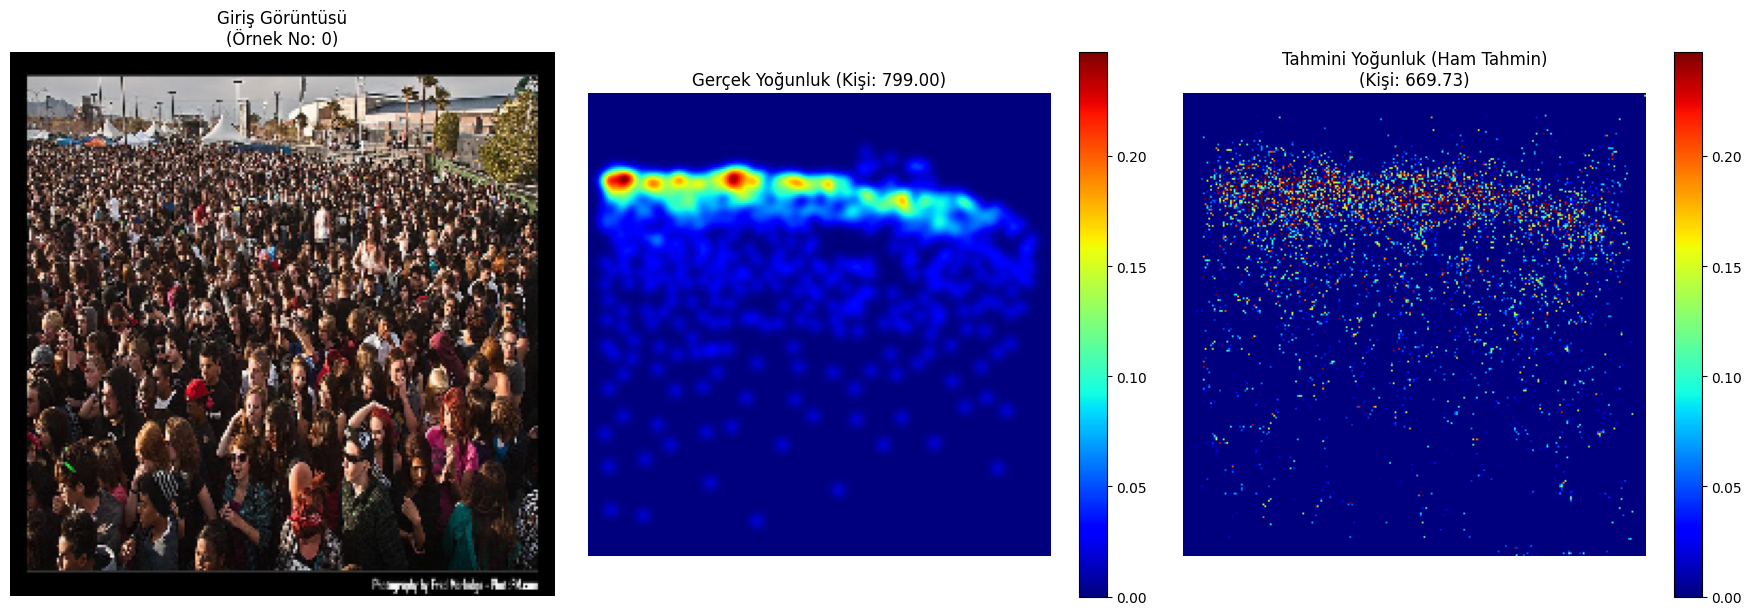

    Gerçek Sayı: 799.00, Ham Tahmini Sayı: 669.73

  Durum: Pürüzsüzleştirilmiş (Sigma = 0.5)


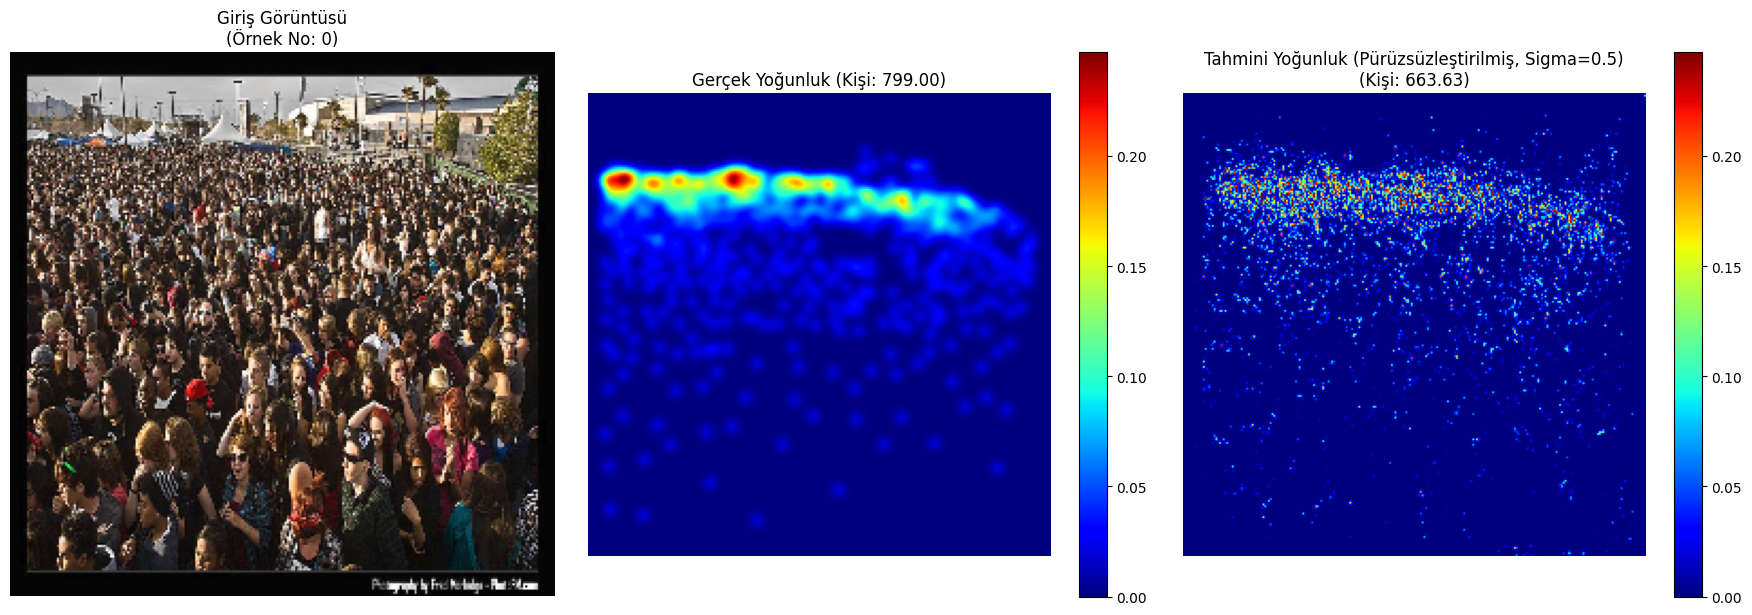


  Durum: Pürüzsüzleştirilmiş (Sigma = 1.0)


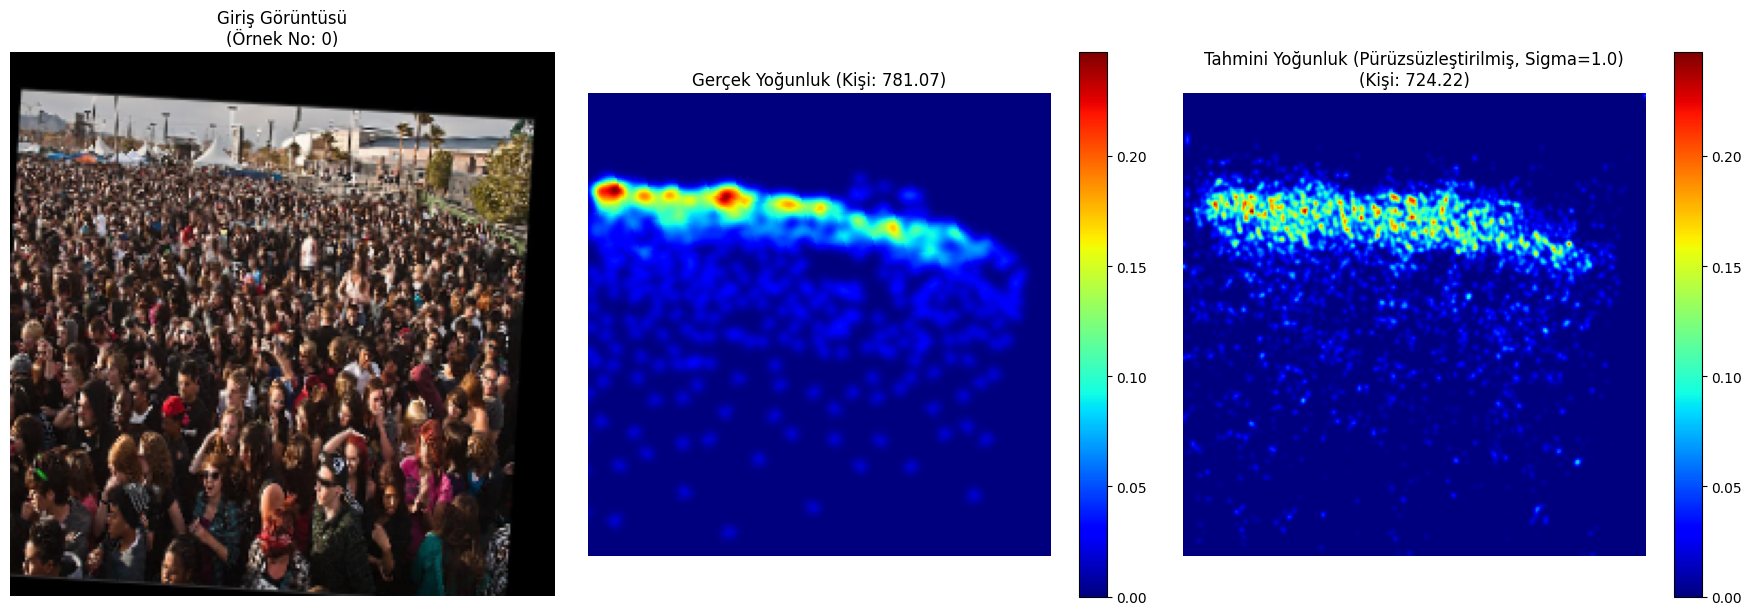


  Durum: Pürüzsüzleştirilmiş (Sigma = 1.5)


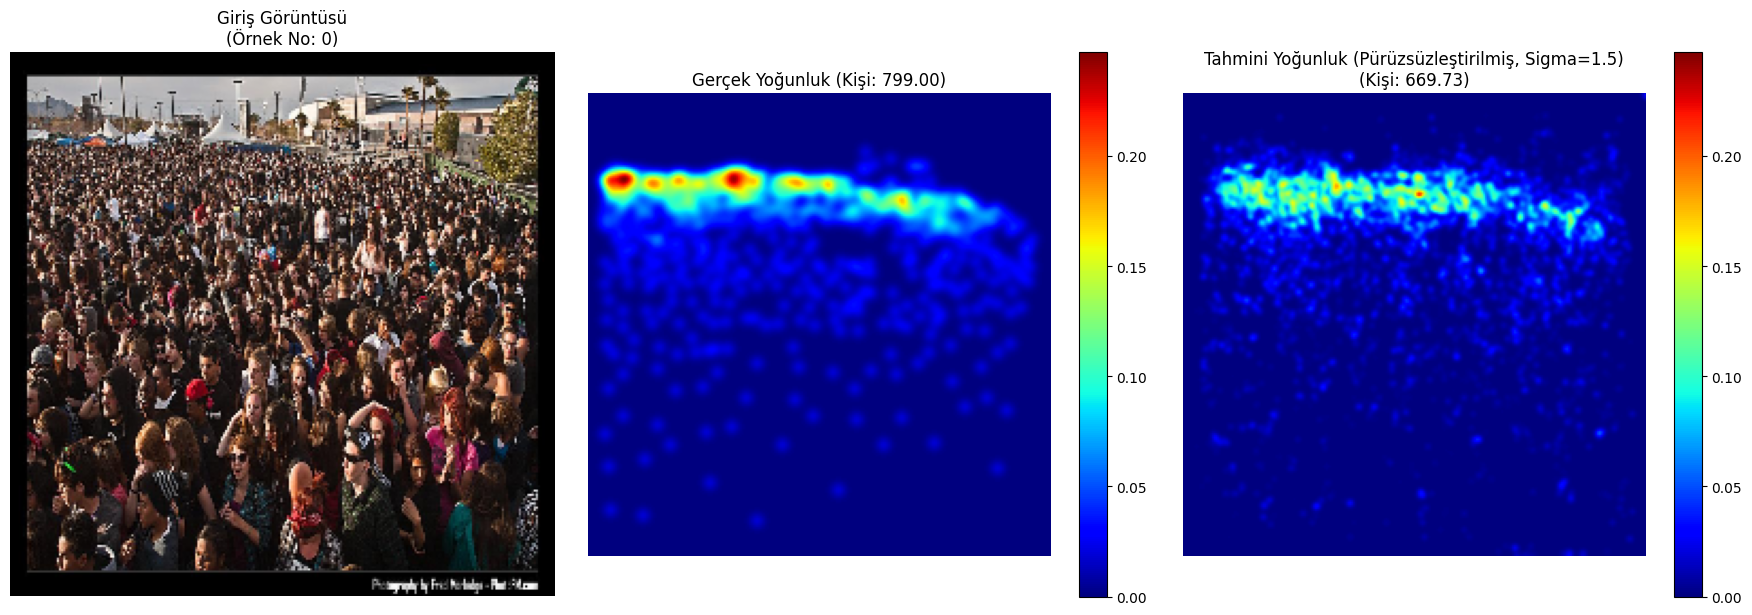


  Durum: Pürüzsüzleştirilmiş (Sigma = 2.0)


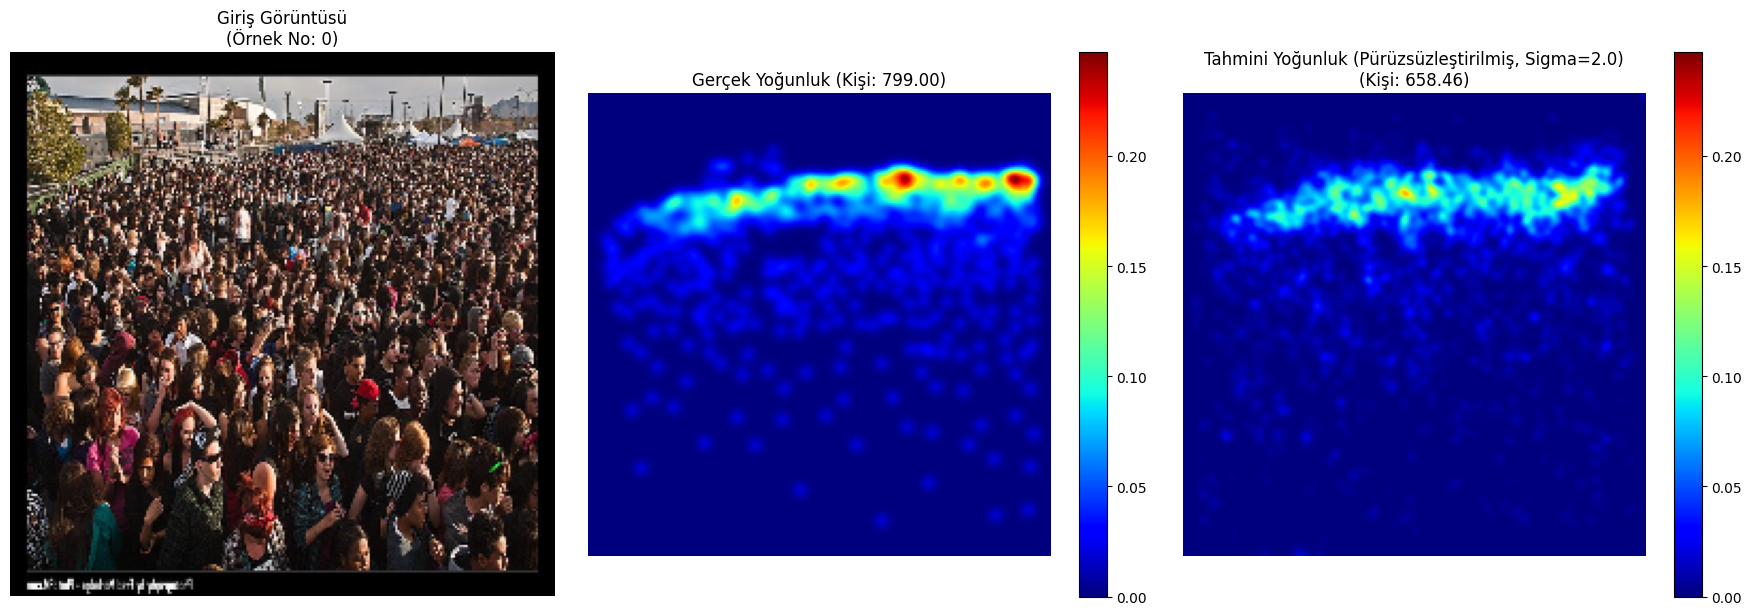

In [13]:
model_for_comparison = CrowdCNN(pretrained=False).to(device) 
    
best_model_path_comp = r"C:/Users/ASUS/OneDrive/Masaüstü/VisualCrowdDensityEstimation/model_MAE146.65_sigma3_lossW15_LR3e-5.pth" # EN İYİ MODELİN YOLU

if os.path.exists(best_model_path_comp):
    try:
        model_for_comparison.load_state_dict(torch.load(best_model_path_comp, map_location=device))
        print(f"Model '{best_model_path_comp}' adresinden karşılaştırma için başarıyla yüklendi.")
        model_for_comparison.eval() 
        
        if 'val_dataset' in locals() and len(val_dataset) > 0:
            idx_to_compare_on = 0 
            if idx_to_compare_on >= len(val_dataset):
                print(f"Uyarı: Seçilen örnek indeksi ({idx_to_compare_on}) doğrulama seti boyutundan büyük. Atlanıyor.")
            else:
                print(f"\n--- Doğrulama Setinden Örnek {idx_to_compare_on} Üzerinde Farklı Pürüzsüzleştirme Sigmaları ---")


                image_tensor_orig, true_density_tensor_orig = val_dataset[idx_to_compare_on]
                input_tensor_orig = image_tensor_orig.unsqueeze(0).to(device)

                with torch.no_grad():
                    output_density_tensor_raw = model_for_comparison(input_tensor_orig)
                predicted_density_np_raw_base = output_density_tensor_raw.squeeze().cpu().numpy()
                
                print(f"\n--- Karşılaştırma: Örnek {idx_to_compare_on} ---")
                
                # 1. Ham Tahmin
                print("  Durum: Ham Tahmin (Pürüzsüzleştirme Yok)")
                raw_c, _, true_c = visualize_prediction_comparison(
                    model_for_comparison, val_dataset, idx_to_compare_on, device, 
                    apply_smoothing=False
                )
                if raw_c is not None: 
                    print(f"    Gerçek Sayı: {true_c:.2f}, Ham Tahmini Sayı: {raw_c:.2f}")
                # 2. Sigma = 0.5 ile Pürüzsüzleştirme
                print("\n  Durum: Pürüzsüzleştirilmiş (Sigma = 0.5)")
                raw_c, smoothed_c_0_5, _ = visualize_prediction_comparison(
                    model_for_comparison, val_dataset, idx_to_compare_on, device, 
                    apply_smoothing=True, smoothing_sigma=0.5
                )
                # 3. Sigma = 1.0 ile Pürüzsüzleştirme
                print("\n  Durum: Pürüzsüzleştirilmiş (Sigma = 1.0)")
                raw_c, smoothed_c_1_0, _ = visualize_prediction_comparison(
                    model_for_comparison, val_dataset, idx_to_compare_on, device, 
                    apply_smoothing=True, smoothing_sigma=1.0
                )
                # 4. Sigma = 1.5 ile Pürüzsüzleştirme
                print("\n  Durum: Pürüzsüzleştirilmiş (Sigma = 1.5)")
                raw_c, smoothed_c_1_5, _ = visualize_prediction_comparison(
                    model_for_comparison, val_dataset, idx_to_compare_on, device, 
                    apply_smoothing=True, smoothing_sigma=1.5
                )
                # 5. Sigma = 2.0 ile Pürüzsüzleştirme
                print("\n  Durum: Pürüzsüzleştirilmiş (Sigma = 2.0)")
                raw_c, smoothed_c_2_0, _ = visualize_prediction_comparison(
                    model_for_comparison, val_dataset, idx_to_compare_on, device, 
                    apply_smoothing=True, smoothing_sigma=2.0
                )
        else:
            print("Doğrulama seti (val_dataset) bulunamadı veya boş. Karşılaştırmalı görselleştirme atlanıyor.")

    except Exception as e:
        print(f"Model yükleme veya görselleştirme sırasında bir hata oluştu: {e}")
else:
    print(f"HATA: Model dosyası ('{best_model_path_viz}') bulunamadı. Lütfen yolu kontrol edin.")